DenseNet-Densely Connected Convolutional Networks
===

# 1.DenseNet介绍
CNN史上的一个里程碑事件是ResNet模型的出现，ResNet可以训练出更深的CNN模型，从而实现更高的准确度。

ResNet模型的核心是通过建立前面层与后面层之间的“短路连接”(shortcuts，skip connection)，这有助于训练过程中梯度的反向传播，从而能训练出更深的CNN网络。

DenseNet基本思路与ResNet一致，但是它建立的是前面所有层与后面层的密集连接(dense connection)，它的名称也是由此而来。

DenseNet的另一大特色是通过特征在channel上的连接来实现特征重用(feature reuse)。这些特点让DenseNet在参数和计算成本更少的情形下实现比ResNet更优的性能。

# 2.DenseNet设计理念
DenseNet提出了一个更激进的密集连接机制：即互相连接所有的层，具体来说就是每个层都会接受其前面所有层作为其额外的输入。下图ResNet的网络联结机制

![image](Images/05_001.jpg)

下图为DenseNet的密集连接机制

![image](Images/05_002.jpg)

可以看到，ResNet是每个层与前面的某层(一般是2~3层)短路连接在一起，连接方式是通过元素级相加。

而在DenseNet中，每个层都会与前面所有层在channel维度上连接在一起(这里各个层的特征图大小是相同的),并作为下一层的输入。对于一个$L$层的网络，DenseNet共包含$\frac{L(L+1)}{2}$个连接

相比ResNet，这是一种密集连接。而且DenseNet是直接concat来自不同层的特征图，这可以实现特征重用，提升效率，这一特点是DenseNet与ResNet最主要的区别。

如果用公式表示的话，传统的网络在$l$层的输出为
$$x_l=H_l(x_{l-1})$$
而对于ResNet，增加了来自上一层输入的identity函数
$$x_l=H_l(x_{l-1})+x_{l-1}$$
在DenseNet中，会连接前面所有层作为输入
$$x_l=H_l([x_0,x_1,x_2,...,x_{l-1}])$$
其中，上面的$H_l(\dot)$代表是非线性转化函数(non-liear transformation)，它是一个组合操作，其可能包括一系列的Batch Normalization，ReLU，Pooling及Conv操作。

注意这里$l$层与$l-1$层之间可能实际上包含多个卷积层。DenseNet的前向过程如下图所示，可以更直观地理解其密集连接方式

![image](Images/05_003.jpg)

比如$h_3$的输入不仅包括来自$h_2$的$x_2$，还包括前面两层的$x_1$和$x_2$，它们是在channel维度上连接在一起的。

CNN网络一般要经过Pooling或者stride>1的Conv来降低特征图的大小，而DenseNet的密集连接方式需要特征图大小保持一致。

为了解决这个问题，DenseNet网络中使用DenseBlock+Transition的结构，其中DenseBlock是包含很多层的模块，每个层的特征图大小相同，层与层之间采用密集连接方式。

而Transition模块是连接两个相邻的DenseBlock，并且通过Pooling使特征图大小降低。图4给出了DenseNet的网路结构，它共包含4个DenseBlock，各个DenseBlock之间通过Transition连接在一起。

![image](Images/05_004.jpg)

# 3.网络结构
![image](Images/05_005.jpg)

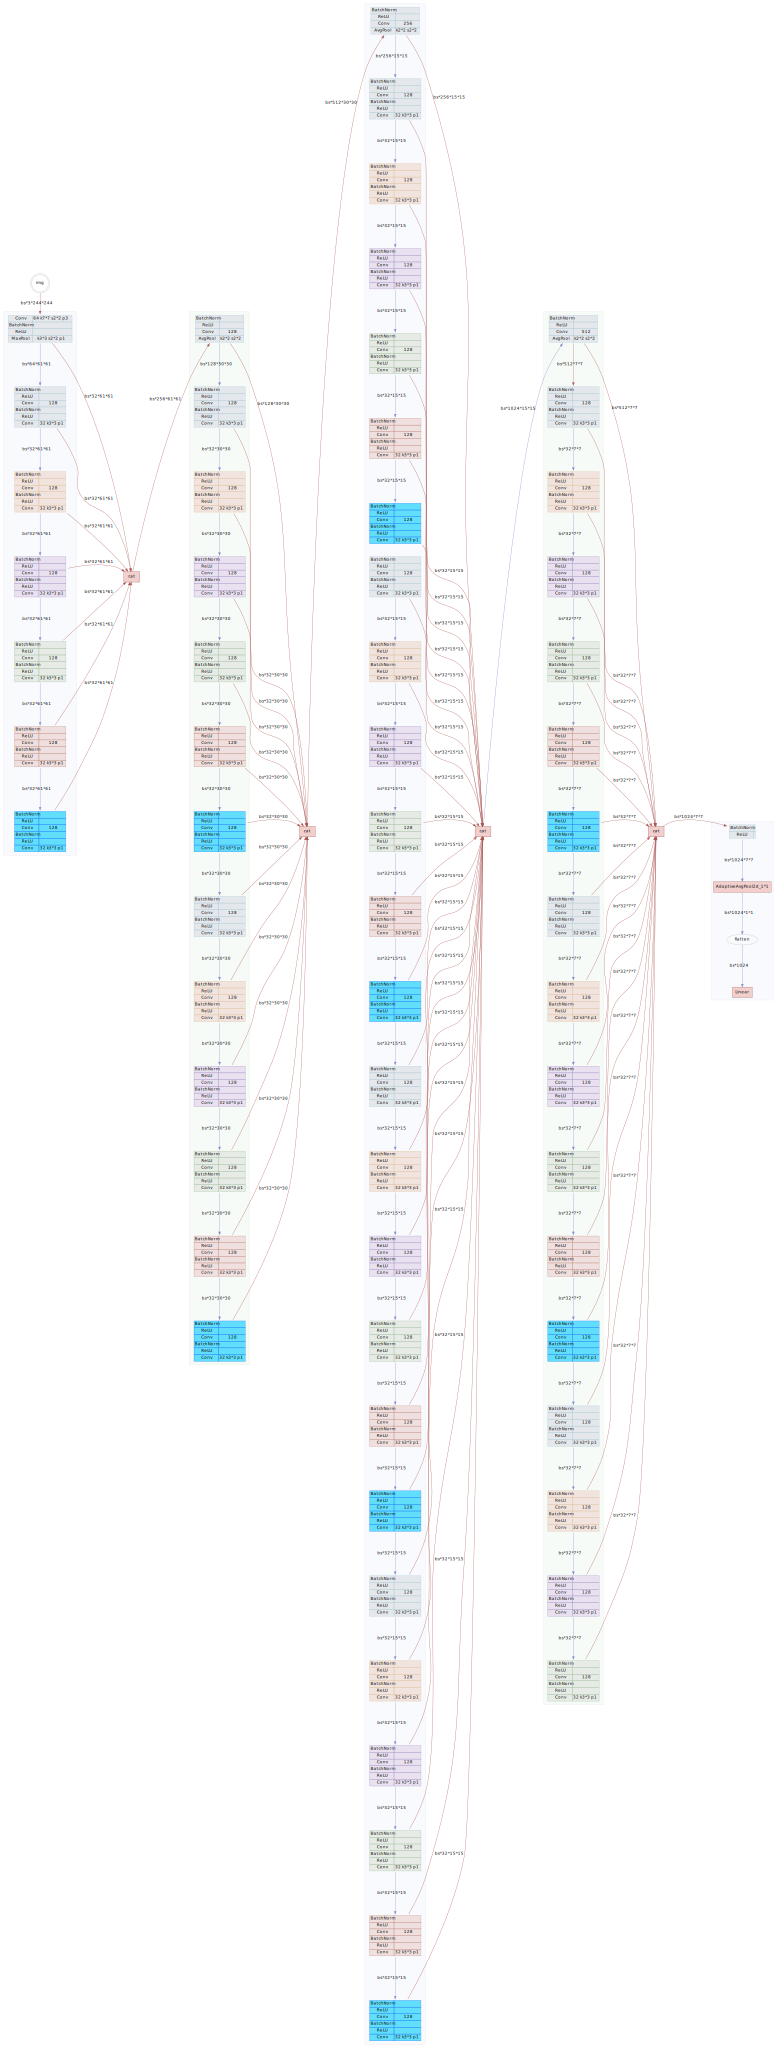

In [1]:
import graphviz

FONT_NAME = "Fira Code Retina"
graph = graphviz.Digraph(name="DenseNet121", format='png', node_attr={'shape': 'plaintext'}, edge_attr = {"constraint":"false"})
graph.attr(rankdir="LR", nodesep="0.5")

with graph.subgraph(name="cluster1") as sub1:
    sub1.attr(color="#E3E5EF", bgcolor="#F9FAFE")
    with graph.subgraph() as s:
        s.node("block1", '''<
            <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
            <tr><td>Conv</td><td>64 k7*7 s2*2 p3</td></tr>
            <tr><td>BatchNorm</td><td></td></tr>
            <tr><td>ReLU</td><td></td></tr>
            <tr><td>MaxPool</td><td>k3*3 s2*2 p1</td></tr>
            </table>
            >''', fontname=FONT_NAME)
        s.node('block2', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block3', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block4', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block5', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block6', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#EFE0DF" color="#C08B7B">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block7', '''<
            <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#61DEFC" color="#2075F8">
            <tr><td>BatchNorm</td><td></td></tr>
            <tr><td>ReLU</td><td></td></tr>
            <tr><td>Conv</td><td>128</td></tr>
            <tr><td>BatchNorm</td><td></td></tr>
            <tr><td>ReLU</td><td></td></tr>
            <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
            </table>
            >''', fontname=FONT_NAME)
    sub1.edge("block1", "block2", color="#7D88C7", label="bs*64*61*61", fontname=FONT_NAME)
    sub1.edge("block2", "block3", color="#7D88C7", label="bs*32*61*61", fontname=FONT_NAME)
    sub1.edge("block3", "block4", color="#7D88C7", label="bs*32*61*61", fontname=FONT_NAME)
    sub1.edge("block4", "block5", color="#7D88C7", label="bs*32*61*61", fontname=FONT_NAME)
    sub1.edge("block5", "block6", color="#7D88C7", label="bs*32*61*61", fontname=FONT_NAME)
    sub1.edge("block6", "block7", color="#7D88C7", label="bs*32*61*61", fontname=FONT_NAME)

graph.node('img', shape="doublecircle", color="grey", fontname=FONT_NAME)
graph.edge("img", "block1", label="bs*3*244*244", color="#AC5553", fontname=FONT_NAME)

graph.node("block8", shape="box", label="cat", color="#A25954", style="filled", fillcolor="#F1CFCD", fontname=FONT_NAME)
graph.edge("block1", "block8", label="bs*32*61*61", color="#AC5553", fontname=FONT_NAME)
graph.edge("block2", "block8", label="bs*32*61*61", color="#AC5553", fontname=FONT_NAME)
graph.edge("block3", "block8", label="bs*32*61*61", color="#AC5553", fontname=FONT_NAME)
graph.edge("block4", "block8", label="bs*32*61*61", color="#AC5553", fontname=FONT_NAME)
graph.edge("block5", "block8", label="bs*32*61*61", color="#AC5553", fontname=FONT_NAME)
graph.edge("block6", "block8", label="bs*32*61*61", color="#AC5553", fontname=FONT_NAME)
graph.edge("block7", "block8", label="bs*32*61*61", color="#AC5553", fontname=FONT_NAME)

graph.node("T0", style="invis")
graph.edge("block4", "T0", constraint="true", style="invis")
graph.edge("T0", "block8", constraint="true", style="invis")

with graph.subgraph(name="cluster2") as sub2:
    sub2.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block9', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>AvgPool</td><td>k2*2 s2*2</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block10', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block11', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block12', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block13', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block14', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#EFE0DF" color="#C08B7B">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block15', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#61DEFC" color="#2075F8">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block16', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block17', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block18', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block19', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block20', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#EFE0DF" color="#C08B7B">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block21', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#61DEFC" color="#2075F8">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)

    sub2.edge("block9", "block10", label="bs*128*30*30", color="#7D88C7", fontname=FONT_NAME)
    sub2.edge("block10", "block11", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)
    sub2.edge("block11", "block12", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)
    sub2.edge("block12", "block13", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)
    sub2.edge("block13", "block14", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)
    sub2.edge("block14", "block15", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)
    sub2.edge("block15", "block16", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)
    sub2.edge("block16", "block17", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)
    sub2.edge("block17", "block18", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)
    sub2.edge("block18", "block19", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)
    sub2.edge("block19", "block20", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)
    sub2.edge("block20", "block21", color="#7D88C7", label="bs*32*30*30", fontname=FONT_NAME)

graph.node("block22", shape="box", label="cat", color="#A25954", style="filled", fillcolor="#F1CFCD",fontname=FONT_NAME)

graph.edge("block9", "block22", label="bs*128*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block10", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block11", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block12", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block13", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block14", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block15", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block16", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block17", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block18", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block19", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block20", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)
graph.edge("block21", "block22", label="bs*32*30*30", color="#AC5553", fontname=FONT_NAME)

graph.node("T1", style="invis")
graph.edge("block8", "T1", constraint="true", style="invis")
graph.edge("T1", "block12", constraint="true", style="invis")
graph.edge("block8", "block9", label="bs*256*61*61", color="#AC5553", fontname=FONT_NAME)

graph.node("T2", style="invis")
graph.edge("block15", "T2", constraint="true", style="invis")
graph.edge("T2", "block22", constraint="true", style="invis")

with graph.subgraph(name="cluster3") as sub3:
    sub3.attr(color="#E3E5EF", bgcolor="#F9FAFE")
    with graph.subgraph() as s:
        s.node('block23', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>256</td></tr>
                    <tr><td>AvgPool</td><td>k2*2 s2*2</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block24', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block25', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block26', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block27', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block28', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#EFE0DF" color="#C08B7B">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block29', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#61DEFC" color="#2075F8">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block30', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block31', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block32', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block33', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block34', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#EFE0DF" color="#C08B7B">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block35', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#61DEFC" color="#2075F8">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block36', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block37', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block38', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block39', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block40', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#EFE0DF" color="#C08B7B">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block41', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#61DEFC" color="#2075F8">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block42', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>128</td></tr>
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block43', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>128</td></tr>
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block44', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>128</td></tr>
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block45', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>128</td></tr>
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block46', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#EFE0DF" color="#C08B7B">
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>128</td></tr>
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block47', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#61DEFC" color="#2075F8">
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>128</td></tr>
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub3.edge("block23", "block24", label="bs*256*15*15", color="#7D88C7", fontname=FONT_NAME)
    sub3.edge("block24", "block25", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block25", "block26", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block26", "block27", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block27", "block28", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block28", "block29", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block30", "block31", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block31", "block32", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block32", "block33", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block33", "block34", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block34", "block35", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block35", "block36", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block36", "block37", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block37", "block38", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block38", "block39", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block39", "block40", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block40", "block41", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block41", "block42", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block42", "block43", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block43", "block44", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block44", "block45", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block45", "block46", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)
    sub3.edge("block46", "block47", color="#7D88C7", label="bs*32*15*15", fontname=FONT_NAME)

graph.node("block48", shape="box", label="cat", color="#A25954", style="filled", fillcolor="#F1CFCD",
           fontname=FONT_NAME)
graph.edge("block23", "block48", label="bs*256*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block24", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block25", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block26", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block27", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block28", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block29", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block30", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block31", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block32", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block33", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block34", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block35", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block36", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block37", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block38", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block39", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block40", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block41", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block42", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block43", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block44", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block45", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block46", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)
graph.edge("block47", "block48", label="bs*32*15*15", color="#AC5553", fontname=FONT_NAME)

graph.node("T3", style="invis")
graph.edge("block22", "T3", constraint="true", style="invis")
graph.edge("T3", "block33", constraint="true", style="invis")
graph.edge("block22", "block23", label="bs*512*30*30", color="#AC5553", fontname=FONT_NAME)

graph.node("T4", style="invis")
graph.edge("block33", "T4", constraint="true", style="invis")
graph.edge("T4", "block48", constraint="true", style="invis")

with graph.subgraph(name="cluster4") as sub4:
    sub4.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block49', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>512</td></tr>
                    <tr><td>AvgPool</td><td>k2*2 s2*2</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block50', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block51', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block52', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block53', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block54', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#EFE0DF" color="#C08B7B">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block55', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#61DEFC" color="#2075F8">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block56', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block57', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block58', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block59', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block60', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#EFE0DF" color="#C08B7B">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block61', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#61DEFC" color="#2075F8">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block62', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block63', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block64', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block65', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>128</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>32 k3*3 p1</td></tr>
                </table>
                >''', fontname=FONT_NAME)

    sub4.edge("block49", "block50", label="bs*512*7*7", color="#AC5553", fontname=FONT_NAME)
    sub4.edge("block50", "block51", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block51", "block52", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block52", "block53", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block53", "block54", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block54", "block55", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block55", "block56", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block56", "block57", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block57", "block58", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block58", "block59", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block59", "block60", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block60", "block61", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block61", "block62", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block62", "block63", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block63", "block64", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)
    sub4.edge("block64", "block65", color="#7D88C7", label="bs*32*7*7", fontname=FONT_NAME)

graph.node("block66", shape="box", label="cat", color="#A25954", style="filled", fillcolor="#F1CFCD",fontname=FONT_NAME)
graph.edge("block49", "block66", label="bs*512*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block50", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block51", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block52", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block53", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block54", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block55", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block56", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block57", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block58", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block59", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block60", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block61", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block62", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block63", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block64", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)
graph.edge("block65", "block66", label="bs*32*7*7", color="#AC5553", fontname=FONT_NAME)

graph.node("T5", style="invis")
graph.edge("block48", "T5", constraint="true", style="invis")
graph.edge("T5", "block55", constraint="true", style="invis")
graph.edge("block48", "block49", label="bs*1024*15*15", color="#7D88C7", fontname=FONT_NAME)

graph.node("T6", style="invis")
graph.edge("block55", "T6", constraint="true", style="invis")
graph.edge("T6", "block66", constraint="true", style="invis")

with graph.subgraph(name="cluster5") as sub5:
    sub5.attr(color="#E3E5EF", bgcolor="#F9FAFE")
    with graph.subgraph() as s:
        s.node('block67', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node("block68", shape="box", color="#A25954", style="filled", fillcolor="#F1CFCD",label="AdaptiveAvgPool2d_1*1",fontname=FONT_NAME)
        s.node("block69", shape="ellipse", color="grey", label="flatten", fontname=FONT_NAME)
        s.node("block70", shape="box", color="#A25954", style="filled", fillcolor="#F1CFCD", label="Linear",fontname=FONT_NAME)
    sub5.edge("block67", "block68", color="#7D88C7", label="bs*1024*7*7", fontname=FONT_NAME)
    sub5.edge("block68", "block69", color="#7D88C7", label="bs*1024*1*1", fontname=FONT_NAME)
    sub5.edge("block69", "block70", color="#7D88C7", label="bs*1024", fontname=FONT_NAME)

graph.node("T7", style="invis")
graph.edge("block66", "T7", constraint="true", style="invis")
graph.edge("T7", "block67", constraint="true", style="invis")
graph.edge("block66", "block67", label="bs*1024*7*7", color="#AC5553", fontname=FONT_NAME)
graph